# Naive Bayes Classifiers

by: Andrzej Poniatowski

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [6]:
# preprocess loads data, handles missing values and removes outliers
def preprocess():
    
    #load file
    df = pd.read_csv('datasets/' + FILE_NAME, header=None, na_values = MISSING_SYMBOL)
    
    #IGNORE_COLUMN is a global variable. It's a list of columns that are not to be processed
    if len(IGNORE_COLUMN) >= 0:
        df.drop(IGNORE_COLUMN, axis=1, inplace=True)
    
    # for nominal and ordinal data missing values are filled with class mode
    if DATA_TYPE == 'NOMINAL' or DATA_TYPE == 'ORDINAL':
        for col_with_na in df.columns[df.isna().any()].tolist():
            df[col_with_na] = df.groupby(CLASS_COLUMN)[col_with_na].apply(lambda x: x.fillna(x.mode()[0]))
    
    # for numeric data missing values are filled with class median
    elif DATA_TYPE == 'NUMERIC':
        for col_with_na in df.columns[df.isna().any()].tolist():
            df.fillna(df.groupby(CLASS_COLUMN).transform('median'), inplace=True)
    
    # preprocess handles mixed data by checking column type in global variable ATTRIBUTE_TYPE_MASK
    # the logic for filling missing values is then same as above
    elif DATA_TYPE == 'MIX':
        for col_with_na in df.columns[df.isna().any()].tolist():
            if ATTRIBUTE_TYPE_MASK[col_with_na] == 2:
                df.fillna(df.groupby(CLASS_COLUMN).transform('median'), inplace=True)
            else:
                df[col_with_na] = df.groupby(CLASS_COLUMN)[col_with_na].apply(lambda x: x.fillna(x.mode()[0]))
    
    # here preprocess drops rows with features with Z-score higher than global variable Z_SCORE_THRESHOLD
    df = df[(np.abs(stats.zscore(df.select_dtypes(exclude='object'))) < Z_SCORE_THRESHOLD).all(axis=1)]
    df.reset_index(inplace=True, drop=True)
    
    # data is split into features (x) and labels (y)
    x = df.drop(CLASS_COLUMN, axis=1)
    y = df[CLASS_COLUMN]
    
    # function returns a tuple of features, labels and the complete data frame
    return (x, y, df)

In [7]:
# discretise changes numeric data into nominal values by splitting it into a number of equal width bins

def discretise(df, num_bins, data_type, attribute_type_mask):
    
    # function relies on ATTRIBUTE_TYPE_MASK to process data.
    # the mask is only provided for mixed data, so here the function creates its own mask for the other data types
    if data_type == 'NOMINAL' or data_type == 'ORDINAL':
        attribute_type_mask = [0] * (df.shape[1] - 1)
    elif data_type == 'NUMERIC':
        attribute_type_mask = [2] * (df.shape[1] - 1)
    
    # split into features and labels
    y = df[CLASS_COLUMN]
    x = df.drop(CLASS_COLUMN, axis=1)
    
    # for each feature, it it's numeric replace it with one of num_bins nominal bins
    for i in range(len(x.columns)):
        if attribute_type_mask[i] == 2:
            x[x.columns[i]] = pd.cut(x=x[x.columns[i]].values, bins = num_bins)
    
    # create a discretised_df to be returned along side a features df x and a labels series y
    discretised_df = x.copy()
    discretised_df[CLASS_COLUMN] = y
    
    # sort the columns, so their order is the same as before discretising
    discretised_df = discretised_df.reindex(sorted(df.columns), axis=1)
    
    return (x, y, discretised_df)

In [8]:
# train calculates prior and posterior probabilities for nominal and ordinal data and mu and sigma for numeric data
# results for priors are stored in a dict, posteriors are stored in dicts of dicts of dicts
# both dicts are returned as a tuple

def train(x, y, df, data_type, attribute_type_mask):
    
    n_samples = x.shape[0]
    labels = y.unique().tolist()
    n_features = len(labels)
    
    # for each unique label get its count and divide it by number of samples in data set to get prior probability
    priors = {}
    for label in labels:
        priors[label] = df.loc[df[CLASS_COLUMN] == label, CLASS_COLUMN].count() / n_samples
    
    # function relies on ATTRIBUTE_TYPE_MASK to process data.
    # the mask is only provided for mixed data, so here the function creates its own mask for the other data types
    if data_type == 'NOMINAL' or data_type == 'ORDINAL':
        attribute_type_mask = [0] * x.shape[1]
    elif data_type == 'NUMERIC':
        attribute_type_mask = [2] * x.shape[1]
    
    probabilities = {}
    # iterate through each column
    for i in range(len(x.columns)):
        feature = x.columns[i]
        probabilities[feature] = {}
        
        # for each column iterate through each label
        for label in labels:
            probabilities[feature][label] = {}
            
            # for each label in each column, if the data type is non-numeric
            if attribute_type_mask[i] == 0 or attribute_type_mask[i] == 1:
                # count how many times the value exists, add +1 for Laplace smoothing
                for value in x[feature].unique():
                    p = df.loc[(df[CLASS_COLUMN] == label) & (df[feature] == value),CLASS_COLUMN].count() + 1
                    c = df.loc[df[CLASS_COLUMN] == label, CLASS_COLUMN].count() + len(x[feature].unique())
                    # divide one plus count of each value by the count of the current label plus number of unique features
                    # store probabilities in a dict of dicts of dicts
                    probabilities[feature][label][value] = p/c
                    
            # for each label in each column if the data type is numeric
            elif attribute_type_mask[i] == 2:
                # calculate mean and std, store them in dict of dicts of dicts
                probabilities[feature][label]['mu'] = df.loc[df[CLASS_COLUMN] == label, feature].mean()
                sigma = df.loc[df[CLASS_COLUMN] == label, feature].std()
                probabilities[feature][label]['sigma'] = df.loc[df[CLASS_COLUMN] == label, feature].std()
    
    # return a tuple of dicitonaries containing priors and probabilities
    return (priors, probabilities)

In [9]:
# Predict classes for items in a test dataset

def predict(test_data, priors, probabilities, data_type, attribute_type_mask):
    
    labels = list(priors.keys())
    columns = test_data.columns
    predicted_classes = []
    n_samples = test_data.shape[0]
    
    # function relies on ATTRIBUTE_TYPE_MASK to process data.
    # the mask is only provided for mixed data, so here the function creates its own mask for the other data types
    if data_type == 'NOMINAL' or data_type == 'ORDINAL':
        attribute_type_mask = [0] * n_samples
    elif data_type == 'NUMERIC':
        attribute_type_mask = [2] * n_samples
    
    # iterate through each row of data
    for index, row in test_data.iterrows():
        max_probability = float('-inf')
        max_label = ''
        
        # iterate through each unique label for each row of data
        for label in labels:
            # retrieve the prior
            current_probability = np.log(priors[label])

            # iterate through each feature
            for i in range(len(columns)):
                column = columns[i]
                
                # check the data type of the feature, if non-numeric add log of probability to current_probability
                if attribute_type_mask[i] == 0 or attribute_type_mask[i] == 1:
                    current_probability += np.log(probabilities[column][label][row[column]])
                
                # if numeric, use Gaussian distribution to obtain the probability
                elif attribute_type_mask[i] == 2:
                    mu = probabilities[column][label]['mu']
                    sigma = probabilities[column][label]['sigma']
                    current_probability += np.log(
                        (1 / (sigma * np.sqrt(2 * np.pi)))
                        *(np.power(np.e, -0.5 * np.power(((row[column] - mu) / sigma), 2))))
            
            # the current_probability is higher than the highest one obtained so far for this row
            # overwrite the probability and label with current values
            if current_probability > max_probability:
                max_label = label
                max_probability = current_probability
        
        # add the predicted class to the list of predicted classes
        predicted_classes.append(max_label)
    
    return predicted_classes

In [10]:
# evaluates the performance of a prediction

def evaluate(predictions, ground_truths):
    predictions = list(predictions)
    labels = ground_truths.unique()
    num_labels = len(labels)
    
    # list of ints for storing counts for true/false positives/negatives.
    # a list of ints, rather than just ints to enable one v many evaluation
    TP = [0] * num_labels
    TN = [0] * num_labels
    FP = [0] * num_labels
    FN = [0] * num_labels
    
    # iterate through each label (for one v many comparisons)
    for i in range(num_labels):
        #iterate through each row and store the TP/FP/TN/FN in respective lists
        for j in range(len(predictions)):
            if ground_truths[j] == predictions[j] == labels[i]:
                TP[i] += 1
            elif ground_truths[j] == predictions[j] and predictions[j] != labels[i]:
                TN[i] += 1
            elif ground_truths[j] != predictions[j] and predictions[j] == labels[i]:
                FP[i] += 1
            elif ground_truths[j] != predictions[j] and predictions[j] != labels[i]:
                FN[i] += 1
    
    # calculate accuracy
    accuracy = (sum(TP) + sum(TN)) / (sum(TP) + sum(TN) + sum(FP) + sum(FN))
    
    # calculate precision
    precision = 0
    for i in range(len(TP)):
        # check for existence of TP to avoid divide by zero errors
        if TP[i] == 0:
            continue
        else:
            precision += TP[i] / (TP[i]+FP[i])
    precision /= len(TP)
    
    # calculate recall
    recall = 0
    for i in range(len(TP)):
        # check for existence of TP to avoid divide by zero errors
        if TP[i] == 0:
            continue
        recall += TP[i] / (TP[i] + FN[i])
    recall /= len(TP)
    
    # print out results
    print('Accuracy: {:.3f}'.format(accuracy))
    print('Precision: {:.3f}'.format(precision))
    print('Recall: {:.3f}'.format(recall))
    
    # return result values in a tuple
    return (accuracy, precision, recall)

In [12]:
# all the global variables and functions needed to run the code in one cell

# name of file to load
FILE_NAME = 'wine.data'
# column containing labels (zero indexed)
CLASS_COLUMN = 0
# symbol used to denote missing values
MISSING_SYMBOL = '?'
# list of column indexes to be ignored
IGNORE_COLUMN = []
# data type: one of NOMINAL, ORDINAL, NUMERIC or MIX
DATA_TYPE = 'NUMERIC'
# list of ints standing for data types in mixed datasets (0=nominal, 1=ordinal, 2=numeric), empty list for non-MIX data sets
ATTRIBUTE_TYPE_MASK = []
# Rows with values with a Z-score greater than this value are discarded
Z_SCORE_THRESHOLD = 5

x, y, df = preprocess()

priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

acc, prec, rec = evaluate(predicted_classes, y)

Accuracy: 0.989
Precision: 0.989
Recall: 0.977


### Comparing performance of discretising numeric attributes vs a Gaussian Naive Bayes approach

In [13]:
# prints out accuracy, precision and recall for each bucket size stored in the BUCKETS list

FILE_NAME = 'wine.data'
CLASS_COLUMN = 0
MISSING_SYMBOL = '?'
IGNORE_COLUMN = []
BUCKETS = range(2,20)

# performance values for each bucket count are stored in these lists for graphing later
disc_acc = []
disc_prec = []
disc_rec = []

for i in BUCKETS:
    DATA_TYPE = 'NUMERIC'
    ATTRIBUTE_TYPE_MASK = []

    x, y, df = preprocess()

    x, y, df = discretise(df, i, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
    
    # switch data type to nminal after discretising so that the following functions know that data type has changed
    DATA_TYPE = 'NOMINAL'
    
    priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
    
    predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
    print('Results for {:d} buckets'.format(i))
    t_acc, t_prec, t_rec = evaluate(predicted_classes, y)
    disc_acc.append(t_acc)
    disc_prec.append(t_prec)
    disc_rec.append(t_rec)
    print()

Results for 2 buckets
Accuracy: 0.904
Precision: 0.903
Recall: 0.823

Results for 3 buckets
Accuracy: 0.961
Precision: 0.960
Recall: 0.923

Results for 4 buckets
Accuracy: 0.955
Precision: 0.953
Recall: 0.915

Results for 5 buckets
Accuracy: 0.983
Precision: 0.983
Recall: 0.966

Results for 6 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 7 buckets
Accuracy: 0.978
Precision: 0.977
Recall: 0.956

Results for 8 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 9 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 10 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 11 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 12 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 13 buckets
Accuracy: 0.983
Precision: 0.982
Recall: 0.967

Results for 14 buckets
Accuracy: 0.989
Precision: 0.988
Recall: 0.978

Results for 15 buckets
Accuracy: 0.983
Precision: 0.982
Recall: 0.967

Results for 16

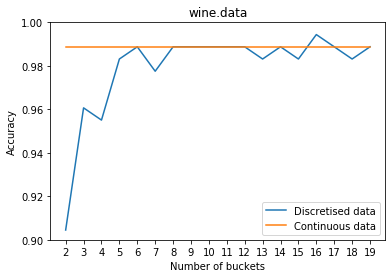

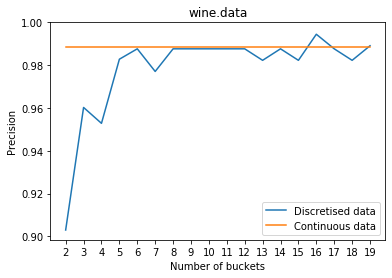

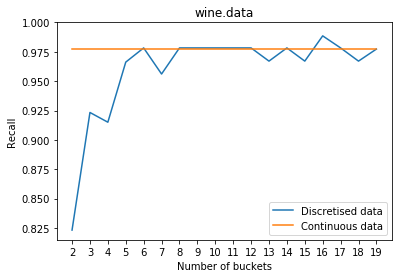

In [14]:
# graph the performance metrics of discretised vs continuous data

plt.plot(BUCKETS, disc_acc, '-', label = 'Discretised data')
plt.plot(BUCKETS, [acc] * len(BUCKETS), label = 'Continuous data')
plt.legend()
plt.title(FILE_NAME)
plt.ylabel('Accuracy')
plt.xlabel('Number of buckets')
bottom, top = plt.ylim()
plt.xticks(BUCKETS)
plt.ylim(bottom, 1)
plt.show()

plt.plot(BUCKETS, disc_prec, '-', label = 'Discretised data')
plt.plot(BUCKETS, [prec] * len(BUCKETS), label = 'Continuous data')
plt.legend()
plt.title(FILE_NAME)
plt.ylabel('Precision')
plt.xlabel('Number of buckets')
bottom, top = plt.ylim()
plt.xticks(BUCKETS)
plt.ylim(bottom, 1)
plt.show()

plt.plot(BUCKETS, disc_rec, '-', label = 'Discretised data')
plt.plot(BUCKETS, [rec] * len(BUCKETS), label = 'Continuous data')
plt.legend()
plt.title(FILE_NAME)
plt.ylabel('Recall')
plt.xlabel('Number of buckets')
bottom, top = plt.ylim()
plt.xticks(BUCKETS)
plt.ylim(bottom, 1)
plt.show()

### Implementing and comparing baseline model (R0) performance with the Naive Bayes classifier

In [19]:
def r_zero(df):
    base_label = list(df[CLASS_COLUMN].mode())
    
    base_line = base_label * df.shape[0]
    return base_line

In [28]:
FILE_NAME = 'wine.data'
CLASS_COLUMN = 0
MISSING_SYMBOL = '?'
IGNORE_COLUMN = []
DATA_TYPE = 'NUMERIC'
ATTRIBUTE_TYPE_MASK = []
Z_SCORE_THRESHOLD = 5

x, y, df = preprocess()

priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
print('Wine data set:')
print("NB performance:")
acc, prec, rec = evaluate(predicted_classes, y)
print()
print("R0 performance:")
base_line = r_zero(df)
b_acc, b_prec, b_rec = evaluate(base_line, y)
print()
print("NB accuracy {:.2f} higher than R0".format(acc-b_acc))
print("NB precision {:.2f} higher than R0".format(prec-b_prec))
print("NB recall {:.2f} higher than R0".format(rec-b_rec))

Wine data set:
NB performance:
Accuracy: 0.989
Precision: 0.989
Recall: 0.977

R0 performance:
Accuracy: 0.399
Precision: 0.133
Recall: 0.333

NB accuracy 0.59 higher than R0
NB precision 0.86 higher than R0
NB recall 0.64 higher than R0


In [33]:
FILE_NAME = 'mushroom.data'
CLASS_COLUMN = 0
MISSING_SYMBOL = '?'
IGNORE_COLUMN = []
DATA_TYPE = 'NOMINAL'
ATTRIBUTE_TYPE_MASK = []
Z_SCORE_THRESHOLD = 5

x, y, df = preprocess()

priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
print('Mushroom data set:')
print("NB performance:")
acc, prec, rec = evaluate(predicted_classes, y)
print()
print("R0 performance:")
base_line = r_zero(df)
b_acc, b_prec, b_rec = evaluate(base_line, y)
print()
print("NB accuracy {:.2f} higher than R0".format(acc-b_acc))
print("NB precision {:.2f} higher than R0".format(prec-b_prec))
print("NB recall {:.2f} higher than R0".format(rec-b_rec))

Mushroom data set:
NB performance:
Accuracy: 0.956
Precision: 0.960
Recall: 0.955

R0 performance:
Accuracy: 0.518
Precision: 0.259
Recall: 0.500

NB accuracy 0.44 higher than R0
NB precision 0.70 higher than R0
NB recall 0.45 higher than R0


In [36]:
FILE_NAME = 'car.data'
CLASS_COLUMN = 6
MISSING_SYMBOL = '?'
IGNORE_COLUMN = []
DATA_TYPE = 'ORDINAL'
ATTRIBUTE_TYPE_MASK = []
Z_SCORE_THRESHOLD = 5

x, y, df = preprocess()

priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
print('Car data set:')
print("NB performance:")
acc, prec, rec = evaluate(predicted_classes, y)
print()
print("R0 performance:")
base_line = r_zero(df)
b_acc, b_prec, b_rec = evaluate(base_line, y)
print()
print("NB accuracy {:.2f} higher than R0".format(acc-b_acc))
print("NB precision {:.2f} higher than R0".format(prec-b_prec))
print("NB recall {:.2f} higher than R0".format(rec-b_rec))

Car data set:
NB performance:
Accuracy: 0.872
Precision: 0.804
Recall: 0.466

R0 performance:
Accuracy: 0.700
Precision: 0.175
Recall: 0.250

NB accuracy 0.17 higher than R0
NB precision 0.63 higher than R0
NB recall 0.22 higher than R0


In [37]:
FILE_NAME = 'adult.data'
CLASS_COLUMN = 14
MISSING_SYMBOL = '?'
IGNORE_COLUMN = []
DATA_TYPE = 'MIX'
ATTRIBUTE_TYPE_MASK = [2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0]
Z_SCORE_THRESHOLD = 5

x, y, df = preprocess()

priors, probabilities = train(x, y, df, DATA_TYPE, ATTRIBUTE_TYPE_MASK)

predicted_classes = predict(x, priors, probabilities, DATA_TYPE, ATTRIBUTE_TYPE_MASK)
print('Adult data set:')
print("NB performance:")
acc, prec, rec = evaluate(predicted_classes, y)
print()
print("R0 performance:")
base_line = r_zero(df)
b_acc, b_prec, b_rec = evaluate(base_line, y)
print()
print("NB accuracy {:.2f} higher than R0".format(acc-b_acc))
print("NB precision {:.2f} higher than R0".format(prec-b_prec))
print("NB recall {:.2f} higher than R0".format(rec-b_rec))

Adult data set:
NB performance:
Accuracy: 0.834
Precision: 0.773
Recall: 0.743

R0 performance:
Accuracy: 0.765
Precision: 0.383
Recall: 0.500

NB accuracy 0.07 higher than R0
NB precision 0.39 higher than R0
NB recall 0.24 higher than R0
